In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
# Function to generate device locations
def generate_device_locations(device_count, bs_location, bs_radius):
  device_locations_polar = np.column_stack([bs_radius * np.sqrt(np.random.rand(device_count)), 2 * np.pi * np.random.rand(device_count)])
  rD = device_locations_polar[:, 0]
  thetaD = device_locations_polar[:, 1]
  device_locations = np.column_stack([bs_location[0] + rD * np.cos(thetaD), bs_location[1] + rD * np.sin(thetaD)])
  return device_locations, rD, thetaD

In [3]:
# Function to generate event locations
def generate_event_locations(event_count, bs_location, bs_radius):
  event_locations_polar = np.column_stack([bs_radius * np.sqrt(np.random.rand(event_count)), 2 * np.pi * np.random.rand(event_count)])
  rE = event_locations_polar[:, 0]
  thetaE = event_locations_polar[:, 1]
  event_locations = np.column_stack([bs_location[0] + rE * np.cos(thetaE), bs_location[1] + rE * np.sin(thetaE)])
  return event_locations, rE, thetaE

In [4]:
# Function to calculate device probabilities based on event locations
def calculate_device_probabilities(device_count, event_count, xD, yD, xE, yE, k):
  device_probabilities = np.zeros(device_count)  # Initialize as a 1D array of zeros for each device
  for d in range(device_count):
    device_x_cord = xD[d]
    device_y_cord = yD[d]
    probMult = 1
    for e in range(event_count):
      event_x_cord = xE[e]
      event_y_cord = yE[e]
      probMult *= (1 - np.exp(-np.sqrt((device_x_cord - event_x_cord) ** 2 + (device_y_cord - event_y_cord) ** 2) / k))
    device_probabilities[d] = 1 - probMult
  return device_probabilities

In [5]:
# Function to generate device alarm status
def generate_device_alarm_status(device_count, device_probabilities):
  random_numbers = np.random.rand(device_count)
  alarm_status = random_numbers < device_probabilities
  return alarm_status

In [6]:
# Function to generate device transmission status
def generate_device_transmission_status(device_count, device_alarm_status):
  transmission_probability = np.zeros(device_count)
  transmission_probability[device_alarm_status] = 1
  random_numbers = np.random.rand(device_count)
  device_status = random_numbers < transmission_probability
  return device_status

In [7]:
def modeling(device_count, event_count, bs_location, bs_radius, k, sparsity, num_samples):
  # Preallocate fixed-size NumPy arrays
  all_EventCount = np.zeros(num_samples, dtype=int)
  all_DeviceActiveCount = np.zeros(num_samples, dtype=int)
  all_DeviceProbability = np.zeros((num_samples, device_count), dtype=float)
  all_DeviceAlarmStatus = np.zeros((num_samples, device_count), dtype=bool)
  all_DeviceStatus = np.zeros((num_samples, device_count), dtype=bool)
  all_DeviceLocations = np.zeros((num_samples, device_count, 2), dtype=float)
  all_DeviceLocationsPolar = np.zeros((num_samples, device_count, 2), dtype=float)
  all_EventLocations = np.zeros((num_samples, event_count, 2), dtype=float)
  all_EventLocationsPolar = np.zeros((num_samples, event_count, 2), dtype=float)

  total_samples = 0
  sample_index = 0
  device_active_mean = 0.0

  while sample_index < num_samples:
    total_samples += 1

    # Generate device locations
    device_locations, rD, thetaD = generate_device_locations(device_count, bs_location, bs_radius)
    xD, yD = device_locations[:, 0], device_locations[:, 1]

    # Generate event locations
    event_locations, rE, thetaE = generate_event_locations(event_count, bs_location, bs_radius)
    xE, yE = event_locations[:, 0], event_locations[:, 1]

    # Compute device probabilities
    device_probabilities = calculate_device_probabilities(device_count, event_count, xD, yD, xE, yE, k)

    # Generate device alarm and transmission status (vectorized)
    device_alarm_status = generate_device_alarm_status(device_count, device_probabilities)
    device_status = generate_device_transmission_status(device_count, device_alarm_status)
    device_active_count = np.sum(device_status)  # Count active devices

    # Running average update for device_active_mean
    device_active_mean += (device_active_count - device_active_mean) / total_samples

    print(f'Sample = {sample_index + 1}, Event Count = {event_count}, Active Devices = {device_active_count}, Mean = {device_active_mean:.3f}')

    if device_active_count == sparsity:
      # Store results in preallocated NumPy arrays
      all_EventCount[sample_index] = event_count
      all_DeviceActiveCount[sample_index] = device_active_count
      all_DeviceProbability[sample_index] = device_probabilities
      all_DeviceAlarmStatus[sample_index] = device_alarm_status
      all_DeviceStatus[sample_index] = device_status
      all_DeviceLocations[sample_index] = device_locations
      all_DeviceLocationsPolar[sample_index] = np.column_stack([rD, thetaD])
      all_EventLocations[sample_index] = event_locations
      all_EventLocationsPolar[sample_index] = np.column_stack([rE, thetaE])

      sample_index += 1  # Move to the next sample
      print(f'Sample {sample_index} completed')

  # Mount Google Drive and save data
  drive.mount('/content/drive')
  np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/e4_general_model.npz',
    all_EventCount=all_EventCount,
    all_DeviceActiveCount=all_DeviceActiveCount,
    all_DeviceProbability=all_DeviceProbability,
    all_DeviceAlarmStatus=all_DeviceAlarmStatus,
    all_DeviceStatus=all_DeviceStatus,
    all_DeviceLocations=all_DeviceLocations,
    all_DeviceLocationsPolar=all_DeviceLocationsPolar,
    all_EventLocations=all_EventLocations,
    all_EventLocationsPolar=all_EventLocationsPolar,
    device_count=device_count,
    event_count=event_count,
    bs_location=bs_location,
    bs_radius=bs_radius,
    k=k,
    sparsity=sparsity,
    num_samples=num_samples
  )

  print('Saved to Google Drive')

In [8]:
# Run the modeling with parameters
modeling(device_count=400,
        event_count=4,
        bs_location=np.array([60, 60]) / 2,
        bs_radius=20,
        k=1.7,
        sparsity=20,
        num_samples=1000)

Streaming output truncated to the last 5000 lines.
Sample = 621, Event Count = 4, Active Devices = 22, Mean = 20.288
Sample = 621, Event Count = 4, Active Devices = 22, Mean = 20.289
Sample = 621, Event Count = 4, Active Devices = 19, Mean = 20.288
Sample = 621, Event Count = 4, Active Devices = 17, Mean = 20.288
Sample = 621, Event Count = 4, Active Devices = 20, Mean = 20.288
Sample 621 completed
Sample = 622, Event Count = 4, Active Devices = 23, Mean = 20.288
Sample = 622, Event Count = 4, Active Devices = 25, Mean = 20.289
Sample = 622, Event Count = 4, Active Devices = 15, Mean = 20.288
Sample = 622, Event Count = 4, Active Devices = 21, Mean = 20.288
Sample = 622, Event Count = 4, Active Devices = 21, Mean = 20.288
Sample = 622, Event Count = 4, Active Devices = 25, Mean = 20.289
Sample = 622, Event Count = 4, Active Devices = 22, Mean = 20.289
Sample = 622, Event Count = 4, Active Devices = 17, Mean = 20.289
Sample = 622, Event Count = 4, Active Devices = 21, Mean = 20.289
Samp

DeviceLocations shape: (400, 2)
EventLocations shape: (4, 2)
DeviceProbability shape: (400,)
DeviceStatus shape: (400,)


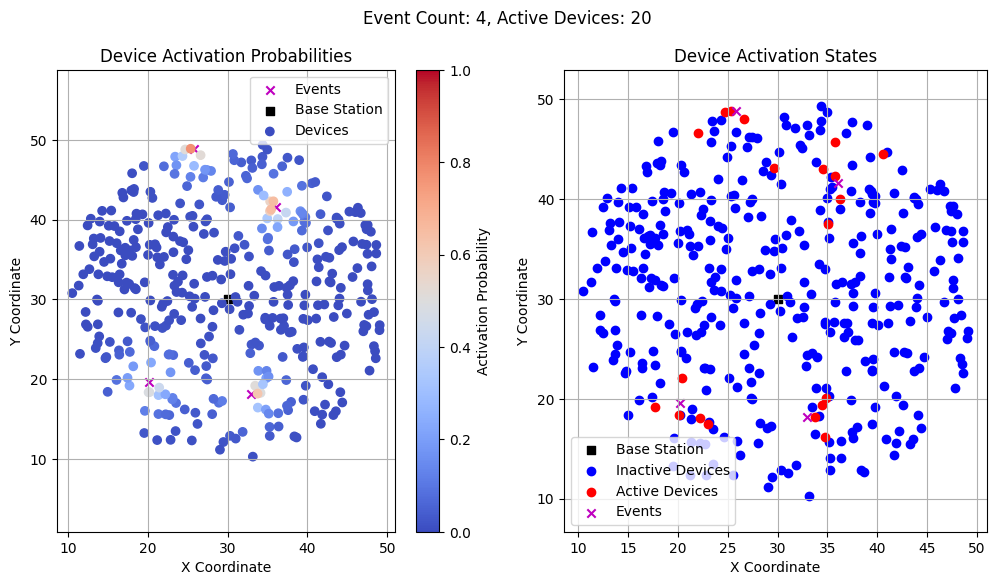

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Load saved data
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/e4_general_model.npz', allow_pickle=True)

# Select sample index (modify if needed)
sample_index = 800

# Extract data from the saved file
EventCount = data['all_EventCount'][sample_index]
DeviceActiveCount = data['all_DeviceActiveCount'][sample_index]
DeviceProbability = data['all_DeviceProbability'][sample_index]
DeviceAlarmStatus = data['all_DeviceAlarmStatus'][sample_index]
DeviceStatus = data['all_DeviceStatus'][sample_index].astype(bool)  # Ensure boolean type
DeviceLocations = data['all_DeviceLocations'][sample_index]
DeviceLocationsPolar = data['all_DeviceLocationsPolar'][sample_index]
EventLocations = data['all_EventLocations'][sample_index]
EventLocationsPolar = data['all_EventLocationsPolar'][sample_index]

# Check the shape of the arrays (for debugging purposes)
print(f"DeviceLocations shape: {DeviceLocations.shape}")
print(f"EventLocations shape: {EventLocations.shape}")
print(f"DeviceProbability shape: {DeviceProbability.shape}")
print(f"DeviceStatus shape: {DeviceStatus.shape}")

# Extract X, Y coordinates for devices and events
xD, yD = DeviceLocations[:, 0], DeviceLocations[:, 1]
xE, yE = EventLocations[:, 0], EventLocations[:, 1]

# Load base station location
bs_location = data['bs_location']

# Plotting
plt.figure(figsize=(12, 6))

# **Subplot 1: Device Active Probabilities**
plt.subplot(1, 2, 1)
plt.scatter(xE, yE, color='m', marker='x', label='Events')  # Event locations
plt.scatter(bs_location[0], bs_location[1], color='k', marker='s', label='Base Station')  # Base station
sc = plt.scatter(xD, yD, c=DeviceProbability, cmap='coolwarm', vmin=0, vmax=1, label='Devices')  # Device probabilities
plt.colorbar(sc, label="Activation Probability")  # Color scale
plt.grid(True)
plt.axis('equal')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Device Activation Probabilities')
plt.legend()

# **Subplot 2: Device Active States**
plt.subplot(1, 2, 2)
plt.scatter(bs_location[0], bs_location[1], color='k', marker='s', label='Base Station')
# Devices that are inactive
plt.scatter(xD[~DeviceStatus], yD[~DeviceStatus], color='b', label='Inactive Devices')
# Devices that are active
plt.scatter(xD[DeviceStatus], yD[DeviceStatus], color='r', label='Active Devices')
plt.scatter(xE, yE, color='m', marker='x', label='Events')
plt.grid(True)
plt.axis('equal')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Device Activation States')
plt.legend()

# **Overall Title**
plt.suptitle(f'Event Count: {EventCount}, Active Devices: {DeviceActiveCount}')

# Show plot
plt.show()


In [10]:
data['all_DeviceStatus'].shape

(1000, 400)